In [1]:
# There exists a theorem in Quantum mechanics called the 
# No-Cloning Theorem: which states that you cannot simply
# make an exact copy of an unknown quantum state.
# However by taking advatange of two classical bits and an
# entangled qubit pair, we can transfer states. 
# We call this Teleportation. 
# To transfer a quantum bit, we must use a third prst to send them
# an entangled qubit pair.
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister,execute, BasicAer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_textbook.tools import random_state, array_to_latex
from qiskit.extensions import Initialize
import numpy as np

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
#Ex:
#creating our circuit:
qr = QuantumRegister(3) # three qubit system
crz = ClassicalRegister(1) # two different calssi
crx = ClassicalRegister(1)
teleportation_Circuit = QuantumCircuit(qr,crz,crx)

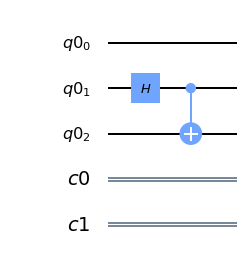

In [3]:
#STEP1:
# creating an entangled pair of qubits.
# This pair creates a special pair called a Bell pair.
# This is done by first placing one qubit into the X-basis: 
# \+> and |->, using a Hadamard gate, then applying a CNOT
# gate onto the other qubit controlled by the on in the X-basis.
def create_bell_pair(qc,a,b):
    """ Creates a bell pair in qc using qubits a and b"""
    qc.h(a) #puts a into |+> 
    qc.cx(a,b) #CNOT with a as control

#creating our bell pair:
create_bell_pair(teleportation_Circuit,1,2)
teleportation_Circuit.draw()

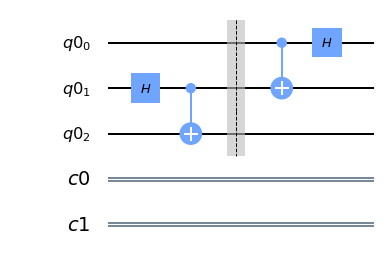

In [4]:
#STEP2:
# We must apply a CNOT gate to the qubit being sent. Then we apply a Hadamard
# gate.
def teleportation_bit(qc,psi,a):
    qc.cx(psi,a)
    qc.h(psi)

#applying teleportation bit to our cicuit;
teleportation_Circuit.barrier()
teleportation_bit(teleportation_Circuit,0,1)
teleportation_Circuit.draw()

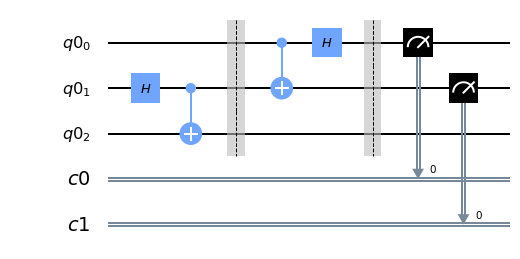

In [5]:
#STEP3:
# Measure both qubits and store the result in two classical bits.
def measure_and_send(qc,a,b):
    """Measures qubits a & b and 'sends' the results to bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
measure_and_send(teleportation_Circuit,0,1)
teleportation_Circuit.draw()

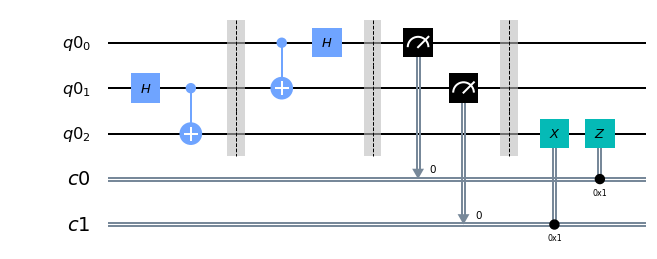

In [6]:
#STEP4:
# Apply gates bepending on the sate of the classical bits:
# 00 -> Do nothing.
# 01 -> Apply X gate.
# 10 -> Apply Z gate.
# 11 -> Apply ZX gate.
def reciever_gates(qc,qubit,crz,crx):
    # apply the correct gates if the registers are in the state '1'
    qc.x(qubit).c_if(crx,1)
    qc.z(qubit).c_if(crz,1)

#Applying reciever gates:
teleportation_Circuit.barrier()
reciever_gates(teleportation_Circuit,2,crz,crx)
teleportation_Circuit.draw()

    

<IPython.core.display.Math object>

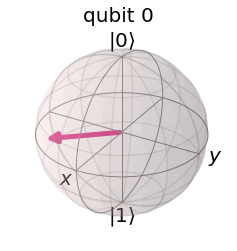

In [7]:
#============================== Begining of testing Protocol =========================================
psi = random_state(1) # create a random 1 qubitstate
# Display our random qubit state:
array_to_latex(psi,pretext="|\\psi\\rangle =")
# Show Block Sphere:
plot_bloch_multivector(psi)

In [8]:
# gate initialiazation: if the circuit is working correctly then q2 will be in this state at the end
init_gate = Initialize(psi)
init_gate.label = "init"

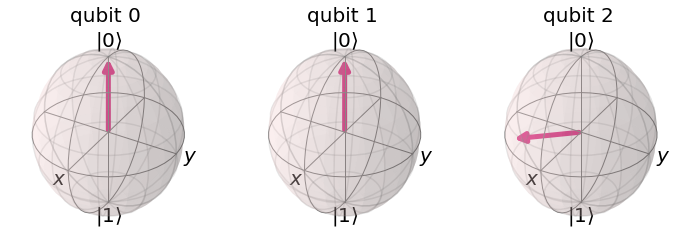

In [9]:
## setup:
qr = QuantumRegister(3)
crz = ClassicalRegister(1)
crx = ClassicalRegister(1)
qc = QuantumCircuit(qr,crz,crx)

# initial step: 0:
#             Initialise q0
qc.append(init_gate,[0])
qc.barrier()

# step 1:
#       begin teleportation protocol
create_bell_pair(qc,1,2)
qc.barrier()

# step 2:
#    send q1 to q0 and q2 to q1
teleportation_bit(qc,0,1)

# step 3:
    #send classical bits from q0 to q1
measure_and_send(qc,0,1)

# step 4:
    #q1 decodes qubits
reciever_gates(qc,2,crz,crx)
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)





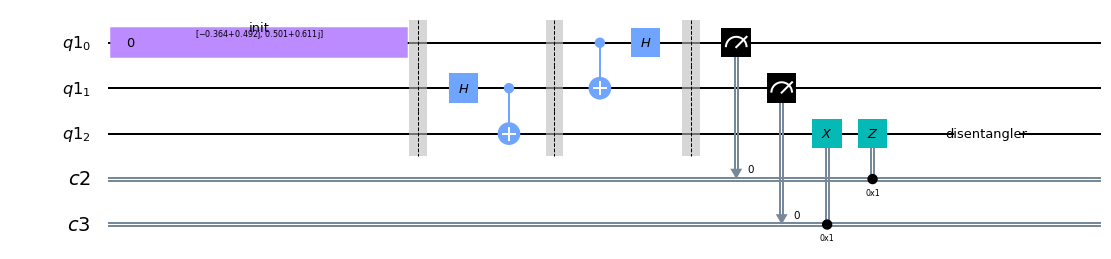

In [10]:
# step 5:
# takes advantafe of the reversablilty of quantum circuits to reverse randomization:
inverse_init_gate = init_gate.gates_to_uncompute() 
qc.append(inverse_init_gate, [2])

#Display circuit:
qc.draw()

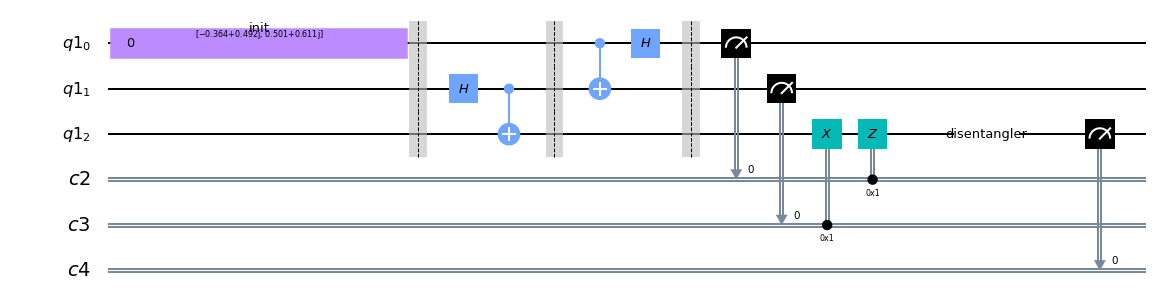

In [11]:

# final step: get result using classical bit:
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

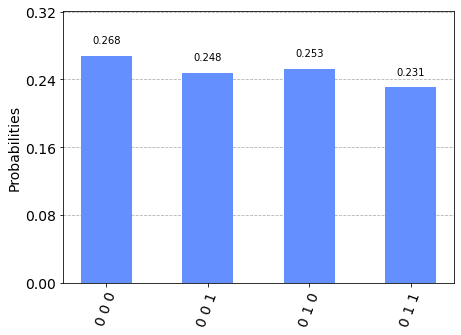

In [12]:
# testing the circuit:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc,backend,shots=1024).result().get_counts()
plot_histogram(counts)

In [13]:
# IBM Quantum computers fo not support instructions after measurements
# however we can use the deferred measurement principle, to postpone
# measurements until the end of our circuit.
# To do this we rewrite our reciever_gates:

In [14]:
def new_reciever_gate(qc,a,b,c):
    qc.cz(a,c)
    qc.cx(b,c)

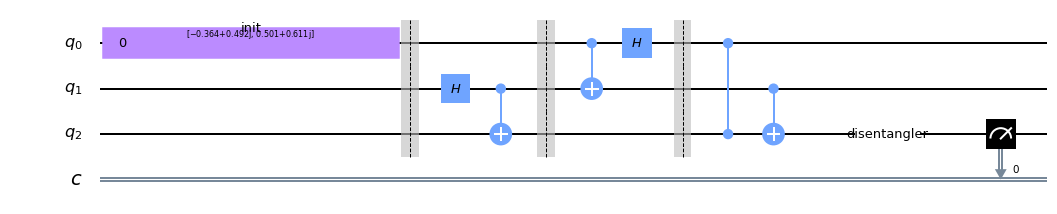

In [15]:
# Using our new reciever function:
qc = QuantumCircuit(3,1)

# First, let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
teleportation_bit(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_reciever_gate(qc, 0, 1, 2)

# We undo the initialisation process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

In [16]:
# now we will use quantum hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

ibmqfactory.load_account:WARNING:2020-06-12 08:35:35,441: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [ ]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)

In [ ]:
# Get results and display:
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_results)
plot_histogram(exp_measurement_results)